In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
nltk.download('stopwords')

In [16]:
df = pd.read_csv("file_temp1.csv", index_col=0, encoding='mac_roman', error_bad_lines=False)
df = df.astype(str)
df.head()

C:\Users\Shajith\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 3163: expected 2 fields, saw 7\nSkipping line 12794: expected 2 fields, saw 4\nSkipping line 12933: expected 2 fields, saw 4\nSkipping line 17852: expected 2 fields, saw 3\nSkipping line 19241: expected 2 fields, saw 3\nSkipping line 20919: expected 2 fields, saw 5\nSkipping line 21002: expected 2 fields, saw 3\nSkipping line 39365: expected 2 fields, saw 5\nSkipping line 46838: expected 2 fields, saw 3\nSkipping line 54623: expected 2 fields, saw 3\nSkipping line 64985: expected 2 fields, saw 10\nSkipping line 68941: expected 2 fields, saw 3\nSkipping line 68949: expected 2 fields, saw 4\nSkipping line 68963: expected 2 fields, saw 6\nSkipping line 69132: expected 2 fields, saw 5\nSkipping line 69133: expected 2 fields, saw 9\nSki

,comment
id,
fgi2pi,"everybody i talk area "" whatever "" camp , infu..."
fgi2pi,"people going get - avoid , helps tremendously ..."
fgi2pi,"i ' feeling hot today . i weird dry cough , li..."
fgi2pi,see rest article infectious disease expert [ d...
fgi2pi,"considering number icu beds , flatten peak sav..."


In [17]:
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

In [18]:
input_data = list(df.comment)

In [19]:
bigram = gensim.models.Phrases(input_data, min_count=15, threshold=75)
trigram = gensim.models.Phrases(bigram[input_data], threshold=75)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
!python -m spacy download en_core_web_sm

In [21]:

nlp = spacy.load('en_core_web_sm')

stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    #Removal of stopwords, conversion to lowercase, and perform lemmatization
    
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [22]:
data_ready = process_words(input_data)

In [ ]:
id2word = corpora.Dictionary(data_ready)

In [24]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [25]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [27]:
extension = dict_df[dict_df.freq>1500].index.tolist()

In [ ]:
# Adding high frequency words to stop words list
stop_words.extend(extension)
data_ready = process_words(input_data)
id2word = corpora.Dictionary(data_ready)

In [31]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
!python -m wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [ ]:
!pip install unzip

In [35]:
import os 
os.environ.update({'MALLET_HOME':r'C:/Users/Shajith/Documents/Mini_project_VIIsem/mallet-2.0.8/'})

In [36]:
mallet_path = r'C:\\Users\\Shajith\\Documents\\Mini_project_VIIsem\\mallet-2.0.8\\bin\\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=100, id2word=id2word)

In [37]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(26,
  [('usa', 0.11470454888922473),
   ('true', 0.0755629439322956),
   ('sad', 0.05773008916427384),
   ('hate', 0.03929273084479371),
   ('exact', 0.03823484962974157),
   ('kind', 0.0377814719661478),
   ('gov', 0.0343055765452622),
   ('wrong', 0.03339882121807466),
   ('accept', 0.03128305878797038),
   ('forget', 0.03007405168505365)]),
 (67,
  [('article', 0.09865536392867583),
   ('canada', 0.08740134463607133),
   ('border', 0.059339374451914645),
   ('site', 0.05115463314820228),
   ('citizen', 0.04399298450745396),
   ('website', 0.03800058462437884),
   ('canadian', 0.03595439929845075),
   ('title', 0.03127740426775796),
   ('page', 0.029377375036539023),
   ('trudeau', 0.017977199649225374)]),
 (50,
  [('hold', 0.10461260174856798),
   ('worry', 0.060596924932167624),
   ('choice', 0.04718118782031957),
   ('hell', 0.0413023816701839),
   ('honestly', 0.04085016581248116),
   ('fair', 0.03587579137775098),
   ('selfish', 0.03451914380464275),
   ('man', 0.0321073258968

In [38]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.5180269351094184


In [39]:
import pickle
pickle.dump(ldamallet, open("ldamallet.pkl", "wb"))

In [40]:
ldamallet = pickle.load(open("ldamallet.pkl", "rb"))

In [41]:
tm_results = ldamallet[corpus]

In [42]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [43]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [44]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
Term1,majority,spend,cancel,mom,student,child,area,wait,kill,chinese,...,assume,supply,check,follow,source,game,cough,level,walk,chance
Term2,exist,save,event,worry,class,parent,county,open,war,culture,...,figure,price,phone,effort,concern,play,fever,rest,house,catch
Term3,type,dollar,suppose,husband,online,learn,washington,minute,dead,ccp,...,infected,sell,note,encourage,contact,fun,cold,isolate,avoid,safe
Term4,resource,worth,trip,dad,university,wait,community,room,boomer,propaganda,...,estimate,demand,write,rule,information,gamestop,breath,top,street,fight
Term5,simply,literally,april,worried,college,elderly,seattle,disney,survive,america,...,base,production,share,harm,subreddit,stuff,throat,quickly,wash,healthy
Term6,manage,million,plan,wife,teacher,surgery,florida,member,society,racist,...,math,profit,enter,user,question,video,pain,idea,foot,bit
Term7,base,waste,weekend,son,teach,grandparent,california,park,generation,english,...,half,produce,list,civil,claim,illegal,dry,begin,crowd,worried
Term8,aware,fix,wedding,sister,professor,adult,mile,window,humanity,western,...,model,product,temperature,racism,action,plague,sore,isolation,door,stand
Term9,fully,throw,date,brother,final,household,rural,full,destroy,medium,...,delay,chain,location,insult,link,switch,chest,similar,safe,curious
Term10,main,gon,postpone,mother,education,option,king,couple,warm,trust,...,expect,shortage,account,remove,message,version,nose,jump,neighbor,worry


In [45]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([' '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df.to_csv('Topics_genrated.csv', sep=' ', index=False ,header=True)
topics_df

C:\Users\Shajith\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic 1,majority exist type resource simply manage base aware fully main ability limited prevent basic vast doubt impossible stick method highly
Topic 2,spend save dollar worth literally million waste fix throw gon billion lose suck honestly greed corporate greedy tree billionaire christ
Topic 3,cancel event suppose trip april plan weekend wedding date postpone vacation tomorrow parade attend party concert patrick refund june book
Topic 4,mom worry husband dad worried wife son sister brother mother visit parent daughter grandma father bring cancer terrify relative recently
Topic 5,student class online university college teacher teach professor final education move exam middle degree grade union depend quarter campus graduate
...,...
Topic 96,game play fun gamestop stuff video illegal plague switch version pokemon book release counter board immigrant gift download card enjoy
Topic 97,cough fever cold breath throat pain dry sore chest nose mild allergy chill breathe common shortness headache negative breathing doc
Topic 98,level rest isolate top quickly idea begin isolation similar jump cure severity immediately head community explain control return wide track
Topic 99,walk house avoid street wash foot crowd door safe neighbor distance dog clean building inside apartment space bathroom hygiene precaution


In [46]:
!pip install wordcloud

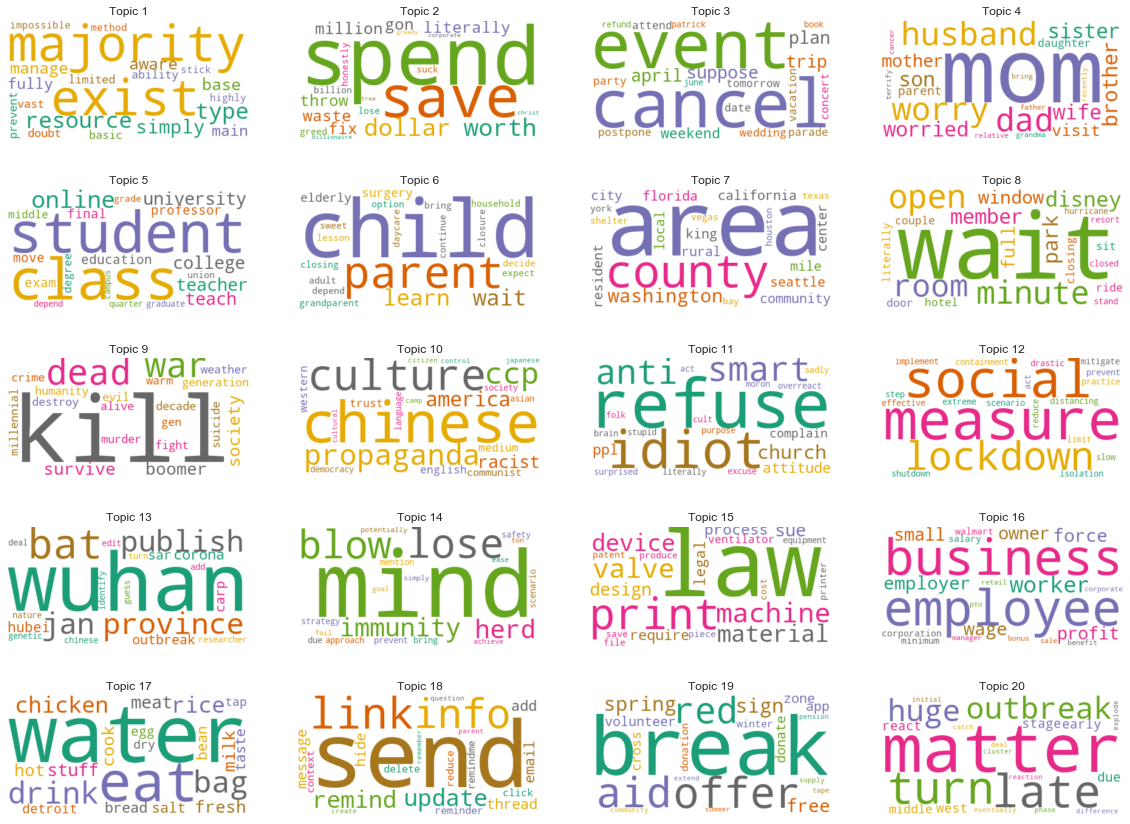

In [47]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(20):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()